# Synthesis of Clickdata via Distribution Expansion using Power-Law Estimation and Linear Interpolation

## Introduction:
The clickstream datasets used to train recommender models offline are often a subset of clicks obtained from the online environment due to various reasons. Firstly, the GDPR law requires user consent for their clicks to be utilized for model training, which many online visitors, such as scraper and SEO bots, do not provide. Secondly, offline datasets are filtered to ensure a minimum support for session length and item support. However, to accurately evaluate the performance of recommendation systems, access to datasets similar to real online behavior is necessary. To address this issue, we propose generating larger datasets with more items that follow the same distribution as visitors who provided consent. Our approach involves estimating the underlying probability distribution and utilizing it to create new samples. We provide code that utilizes power-law estimation and linear interpolation to expand a given distribution.





## Methods:
The code starts by setting up the observed item frequencies and probabilities. Then, the cumulative probability distribution function (CDF) is computed from the observed item probabilities.

Next, the power-law exponent is estimated from the observed frequencies using linear regression. We compute the logarithms of the frequencies and their ranks and fits a straight line to the data using the polyfit() function. The slope of the line is the negative of the power-law exponent.

To generate new probabilities for a given number of items 'm', we create a new array of item indices 'new_idx_list' and computes the logarithm of the probabilities using the estimated power-law exponent and the item indices. The logarithmic probabilities are then converted back to probabilities using the exponential function.

The observed and new item probabilities are then combined, sorted and normalized again to ensure that they sum to 1.

To create a mapping between the cumulative probabilities and the item indices, we use a linear interpolation. The interp1d() function is used to create a function that maps a given cumulative probability to the corresponding item index.

Finally, the code samples new items from the distribution uniformly from the interval (0, 1] and using the inverse of the cumulative distribution function to map them to the corresponding item index. 

## Results:
The code generates a large number of new item samples from the input distribution using the power-law estimation and linear interpolation approach along with their probabilities.

## Discussion:
The presented approach is a simple and efficient way to generate new samples from a given distribution. The accuracy of the results depends on the quality of the input data and the validity of the power-law assumption. In some cases, other distributions or models may be more appropriate, and more advanced statistical techniques may be required. 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import entropy
from scipy import interpolate
from scipy.optimize import curve_fit
import pandas as pd

In [2]:
df = pd.read_csv('../../projects/data/bolcom-clicks-35m_test.txt', sep='\t')
df


,SessionId,Time,ItemId
0,0008019740_18,1585897352,9200000083733268
1,0008019740_18,1585897382,9200000049819763
2,0008019740_18,1585897392,9200000066323079
3,0008019740_18,1585897506,9200000081546242
4,0008019740_18,1585897633,9200000125623273
...,...,...,...
1211470,zzz7jpx6h6yk34srl558w4zg2eu4h4pm_1,1585921127,9200000065118578
1211471,zzz7jpx6h6yk34srl558w4zg2eu4h4pm_1,1585921160,9200000065118570
1211472,zzz7jpx6h6yk34srl558w4zg2eu4h4pm_1,1585921286,9200000064417495
1211473,zzzjsuzmx87wcp4720be75zq67m2hkx9_14,1585944407,9200000026328200


In [3]:
def create_index_df_from_column(argument_df, columnname):
    # create an index for the training item_ids, because we need this when training the model
    # this should be part of the train and serve code of an algorithm
    # usage:
    #     create_index_df_from_column(df, 'ItemId')
    # returns a two column dataframe:
    #   ItemId  idx
    #   9200000105095118    0
    #   9200000041902190    1
    #   9200000095595490    2
    token_id = {t: i for i, t in enumerate(argument_df[columnname].unique())}
    df_index = pd.DataFrame.from_dict(token_id, orient="index").reset_index()
    df_index.rename(columns={"index": columnname, 0: "idx"}, inplace=True)
    return df_index

In [4]:
item_pop_df = df.groupby('ItemId').size()
item_pops_df = item_pop_df.to_frame('qty').reset_index()
item_pops_df.sort_values(by=['qty'], inplace=True)
item_idx = create_index_df_from_column(item_pops_df, 'ItemId')
dfs = item_pops_df.merge(item_idx, on='ItemId')
dfs

,ItemId,qty,idx
0,9200000092996478,1,0
1,9200000066211433,1,1
2,9200000123889779,1,2
3,9200000066211493,1,3
4,9200000066211497,1,4
...,...,...,...
338412,9200000110533529,2073,338412
338413,9200000056292168,2177,338413
338414,9200000026848187,2186,338414
338415,9200000047735877,2224,338415


In [5]:
freq_list = dfs['qty'].to_numpy()
idx_list = dfs['idx'].to_numpy()
p_obs = freq_list / np.sum(freq_list)
p_obs

array([8.25440063e-07, 8.25440063e-07, 8.25440063e-07, ...,
       1.80441198e-03, 1.83577870e-03, 1.92822799e-03])

In [6]:
cdf_obs = np.cumsum(p_obs)    # cumulative distribution function of a random variable

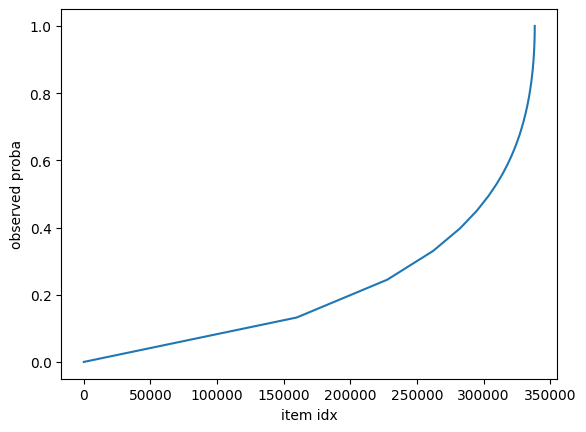

In [7]:
import matplotlib.pyplot as plt
plt.plot(idx_list, cdf_obs)
plt.xlabel('item idx')
plt.ylabel('observed proba')
plt.show()

In [8]:
# Estimate the power-law exponent from the observed frequencies
log_freq = np.log(freq_list)
log_rank = np.log(idx_list + 1)
c, k = np.polyfit(log_rank, log_freq, deg=1)

In [9]:
c,k

(0.5453273807817727, -5.691625174940446)

In [10]:
# Generate probabilities for new items
m = 500000  # number of new items
new_idx_list = np.arange(len(idx_list), len(idx_list) + m)
log_p_new = -k * np.log(new_idx_list + 1) + np.log(c)
p_new = np.exp(log_p_new) / np.sum(np.exp(log_p_new))

In [11]:
# Combine the observed and new item probabilities
p_all = np.concatenate([p_obs, p_new])
p_all = np.sort(p_all)
p_all = p_all / np.sum(p_all)

In [12]:
# Use linear interpolation to create a mapping between the cumulative probabilities and the item IDs
cdf = np.cumsum(p_all)
inv_cdf = interpolate.interp1d(cdf, np.arange(len(p_all)), kind='linear', bounds_error=False, fill_value=(p_all[0], p_all[-1]))


In [13]:
# Sample new items from the distribution
u = np.random.uniform(size=10)
idx = (np.rint(inv_cdf(u))).astype(int)
samples = idx
        
# Print the samples and their probabilities
for item, freq in zip(*np.unique(samples, return_counts=True)):
    print(f"Sampled item {item} with frequency {freq / len(samples)}")

Sampled item 312904 with frequency 0.1
Sampled item 364974 with frequency 0.1
Sampled item 716739 with frequency 0.1
Sampled item 738158 with frequency 0.1
Sampled item 767180 with frequency 0.1
Sampled item 769155 with frequency 0.1
Sampled item 818101 with frequency 0.1
Sampled item 825846 with frequency 0.1
Sampled item 834402 with frequency 0.1
Sampled item 836932 with frequency 0.1


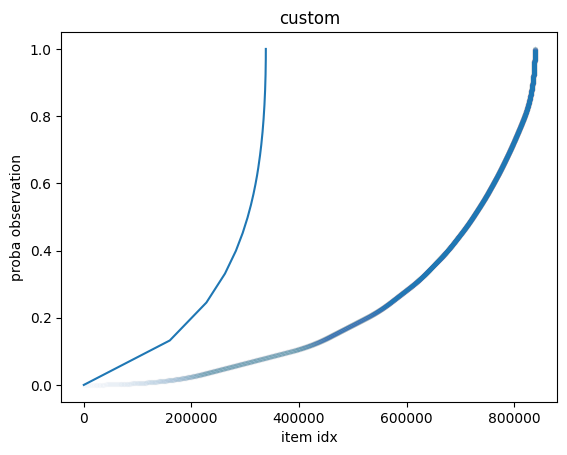

In [14]:

max_i = 10000
u = [i/max_i for i in range(max_i + 1)]
X = (np.rint(inv_cdf(u))).astype(int)
plt.title('custom')
plt.scatter(X, u, marker='.', alpha=0.01)
plt.plot(idx_list, cdf_obs)
plt.xlabel('item idx')
plt.ylabel('proba observation')
plt.show()

In [15]:
kl_divergence_obs_synth = entropy(p_obs, p_new[:len(p_obs)])
print(f"KL-divergence observed to synthetic: {kl_divergence_obs_synth}")
kl_divergence_synth_obs = entropy(p_new[:len(p_obs)], p_obs)
print(f"KL-divergence synthetic to observed: {kl_divergence_synth_obs}")


KL-divergence observed to synthetic: 0.34468472305773246
KL-divergence synthetic to observed: 0.20822646309680742


In [16]:
mae = np.mean(np.abs(p_obs - p_new[:len(p_obs)]))  # mean absolute error
rmse = np.sqrt(np.mean(np.square(p_obs - p_new[:len(p_obs)])))  # root mean squared error
ks = np.max(np.abs(np.cumsum(p_obs) - np.cumsum(p_new[:len(p_obs)])))  # Kolmogorov-Smirnov statistic
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, KS: {ks:.4f}")

MAE: 0.0000, RMSE: 0.0000, KS: 0.7631
